# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Advanced Lane Finding

In [1]:
# import everything we'll need

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle
import random
from moviepy.editor import VideoFileClip

In [2]:
# set parameters

%matplotlib inline

# processing mode
TEST_MODE = False
RECORD = False

# image size
ROWS = 720
COLS = 1280
ROI_TOP = 0.65
ROI_BOTTOM = 0.90
ROI_LEFT = 0.10
ROI_RIGHT = 0.95

# colors and scales
RED_COLOR = (0,0,255)
GREEN_COLOR = (0,255,0)
XM_PER_PIX = 3.7 / 700
YM_PER_PIX = 30 / 720

# camera calibration
CHESS_NX = 9
CHESS_NY = 6

# lane pixel finding
S_THRESHOLD = [170,235]             # range for S-channel yellow lane in HLS color space
L_THRESHOLD = [240,255]             # range for L-channel white lane in HLS color space
L_THRESHOLD_LAB = [195,255]         # range for L channel in LAB color space
SOBEL_THRESHOLD = [30,100]          # range for sobel x derivative

# perspective transform
GB_KERNEL = 3                       # size of gaussian blur kernel
CANNY_LOW = 50                      # canny edge detection threshold (low)
CANNY_HIGH = 400                    # canny edge detection threshold (high)
HOUGH_DIST_RES = 0.5                # hough line finder distance resolution (pixels)
HOUGH_ANGLE_RES = 3.14159/180       # hough line finder angle resolution (rads)
HOUGH_THRESHOLD = 20                # hough line finder threshold
HOUGH_MIN_LINE = 60                 # hough line finder min line length (pixels)
HOUGH_MAX_GAP = 120                 # hough line finder max line gap (pixels)

# lane fitting
NUM_WINS = 8                        # number of sliding windows to use
WIN_WIDTH = 64                      # half total width of sliding window
WIN_HEIGHT = int(ROWS/NUM_WINS)     # total height of sliding window
FRAME_MEMORY = 8                    # number of past frames to remember
LEFT_GUESS = 0.33                    # default fractional guess for left lane
RIGHT_GUESS = 0.75                   # default fractional guess for right lane

# directories and filenames
TEST_DIR = 'test_images'
CALIBRATION_DIR = 'camera_cal'
CALIBRATION_FILENAME = 'camera_calibration.pickle'
PERSPECTIVE_FILENAME = 'perspective_transform.pickle'

OUTPUT_DIR_CALIBRATION = 'output_images/calibration'
OUTPUT_DIR_S_CHANNEL = 'output_images/s_channel'
OUTPUT_DIR_X_GRAD = 'output_images/x_gradient'
OUTPUT_DIR_VP = 'output_images/vanishing_point'

OUTPUT_DIR_UNDISTORT = 'output_images/undistort'
OUTPUT_DIR_WARPED = 'output_images/warped'
OUTPUT_DIR_MARKER_PIXELS = 'output_images/marker_pixels'
OUTPUT_DIR_SLIDING_WINDOW = 'output_images/sliding_window'
OUTPUT_DIR_LANE_MARK = 'output_images/lane_mark'

In [3]:
# define lane class for later use

class LaneLine(object):
    # class to hold info about each lane line

    def __init__(self,side):
        # side: 'left' or 'right'
        self.recentXStartValues = np.zeros((FRAME_MEMORY,),dtype=np.uint16)
        self.recentFits = np.zeros((FRAME_MEMORY,3),dtype=np.float32)      # second-order polynomial: 3 coefficients
        self.foundXStartValue = False
        self.side = side
        self.curvatureRadiusValues = np.zeros((FRAME_MEMORY,),dtype=np.float32)

    def guessLanePosition(self,im):
        
        if self.side == 'left':
            centroid = int(LEFT_GUESS * im.shape[1])
        elif self.side == 'right':
            centroid = int(RIGHT_GUESS * im.shape[1])
        return centroid
        
    def findCentroid(self,im):
        # utility function to find horizontal centroid of distribution

        hist = np.sum(im,axis=0)
        try:
            nonzero = np.flatnonzero(hist)
            if len(nonzero) == 0:
                centroid = self.guessLanePosition(im)
                found = False
            else:
                centroid = int(nonzero.mean())
                found = True
        except:
            centroid = self.guessLanePosition(im)            
            found = False

        return found, centroid

    def calculateCurvature(self,f):
        # calculate radius of curvature
        # use some algebra to scale pixels to meters

        y0 = ROWS * YM_PER_PIX
        A = f[0] *  XM_PER_PIX / YM_PER_PIX**2
        B = f[1] * XM_PER_PIX / YM_PER_PIX
            
        curvature = ((1 + (2*A*y0 + B)**2)**1.5)/float(np.absolute(2*A))
        self.curvatureRadiusValues = np.roll(self.curvatureRadiusValues,1)
        self.curvatureRadiusValues[0] = curvature
          
        return np.mean(self.curvatureRadiusValues)

    def findAndFit(self,im,yVals):
        # find lane centroids and fit to polynomial

        # find x position of lane at bottom of image
        # either use previous frame position (if found) or search again

        if self.foundXStartValue:
            currentXValue = self.recentXStartValues[0]

        else:
            # can't use previous value so have to look for X position of bottom of lane
            # use half of full height to be sure to find it

            if self.side == 'left':
                xLeft = 0
                xRight = int(np.floor(COLS/2))
            elif self.side == 'right':
                xLeft = int(np.ceil(COLS/2))
                xRight = COLS

            roi = im[int(ROWS/2):ROWS,xLeft:xRight]
            found, centroid = self.findCentroid(roi)

            if found:
                currentXValue = centroid + xLeft
                self.foundXStartValue = True
            else:
                # worst case: can't find it, so go with good guess
                currentXValue = self.guessLanePosition(roi)
                self.foundXStartValue = False

        # roll recent X position array by 1; will update first position with fit below
        self.recentXStartValues = np.roll(self.recentXStartValues,1)

        # set up array to hold centroids
        xCentroids = []

        # set up image for drawing centroids
        imFit = np.copy(im)
        imFit = cv2.cvtColor(imFit,cv2.COLOR_GRAY2BGR)

        for i in range(len(yVals)):

            # select window for analysis
            y = yVals[i]
            xLeft, xRight = currentXValue - WIN_WIDTH, currentXValue + WIN_WIDTH
            yBottom, yTop = y, y-WIN_HEIGHT
            roi = im[yTop:yBottom,xLeft:xRight]

            # find centroid in window
            found, centroid = self.findCentroid(roi)
            currentXValue = centroid + xLeft
            xCentroids.append(currentXValue)
            if i == 0:
                self.recentXStartValues[0] = currentXValue
                self.foundXStartValue = found

            # draw fit windows on image
            cv2.rectangle(imFit,(xLeft,yTop),(xRight,yBottom),GREEN_COLOR,1)
            imFit[yTop:yBottom,currentXValue] = RED_COLOR

        # do polynomial fit
        xCentroidsArray = np.array(xCentroids)
        fit = np.polyfit(yVals,xCentroidsArray,2)     # 2nd-order polynomial fit

        # roll recent fit array by 1 and add latest fit
        self.recentFits = np.roll(self.recentFits,1,axis=0)
        self.recentFits[0] = fit

        return imFit

In [4]:
# define camera calibration

def calibrateCamera():
    # use chessboard photos to calibrate camera

    # set termination criteria (for use with cv2.cornerSubPix)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

    # make object points
    objp = np.zeros((CHESS_NX*CHESS_NY,3), np.float32)
    objp[:,:2] = np.mgrid[0:CHESS_NX,0:CHESS_NY].T.reshape(-1,2)
    imagePoints = []
    objectPoints = []

    # loop through calibration images
    for imageFile in os.listdir(CALIBRATION_DIR):
        if imageFile.endswith('.jpg'):

            # read image, grayscale, find corners
            im = cv2.imread(os.path.join(CALIBRATION_DIR,imageFile))
            gray = cv2.cvtColor(im,cv2.COLOR_RGB2GRAY)
            found, corners = cv2.findChessboardCorners(gray,(CHESS_NX,CHESS_NY),None)

            if found:
                # draw corners on image
                cv2.drawChessboardCorners(im,(CHESS_NX,CHESS_NY),corners,found)
                # find corners with higher (sub-pixel) precision
                corners2 = cv2.cornerSubPix(gray,corners,(5,5),(-1,-1),criteria)
                imagePoints.append(corners2)
                objectPoints.append(objp)

                # save image with corners marked
                cv2.imwrite(os.path.join(OUTPUT_DIR_CALIBRATION,imageFile),im)

    # do the actual calibration and save
    ret, mtx, dst, rvecs, tvecs = cv2.calibrateCamera(objectPoints,imagePoints,gray.shape[::-1],None,None)
    imSize = im.shape
    calibrationData = {'cam_matrix':mtx, 'dist_coeffs':dst, 'im_size':imSize}
    with open(CALIBRATION_FILENAME,'wb') as f:
        pickle.dump(calibrationData,f)

    return mtx,dst

Calibrating camera...


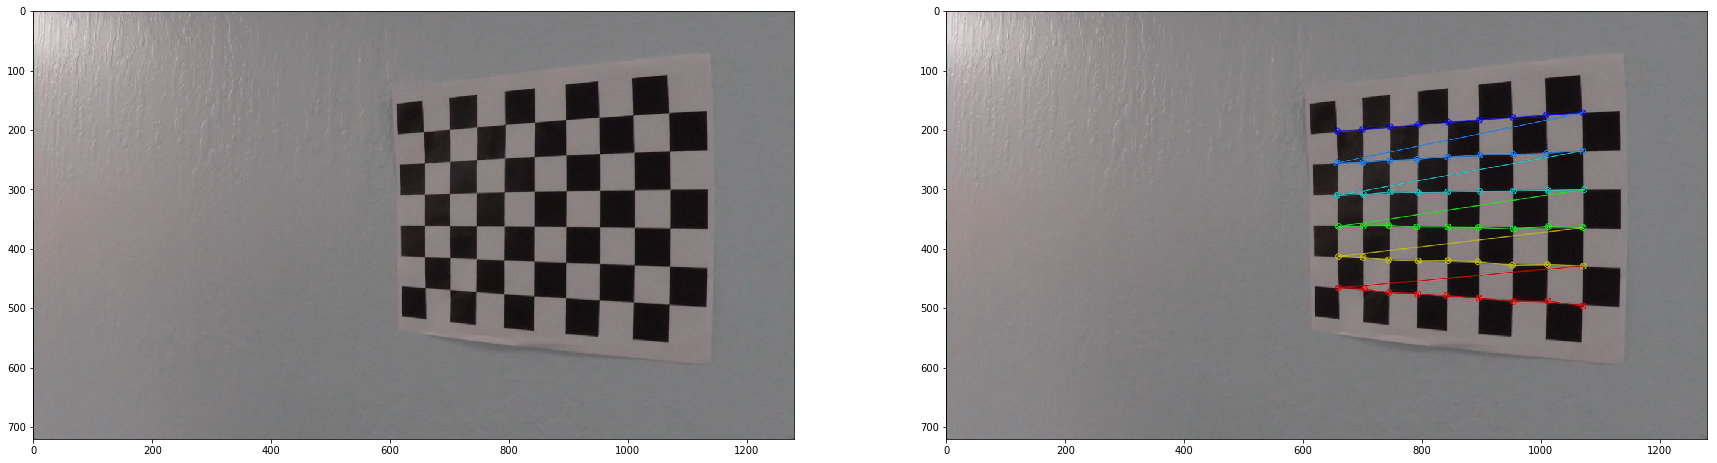

In [6]:
# do camera calibration and display example images

print("Calibrating camera...")
mtx,dst = calibrateCamera()
filenameList = [fn for fn in os.listdir(CALIBRATION_DIR) if fn.endswith('.jpg')]
fn = random.choice(filenameList)
imOriginal = cv2.imread(os.path.join(CALIBRATION_DIR,fn))
imCorners = cv2.imread(os.path.join(OUTPUT_DIR_CALIBRATION,fn))

f = plt.figure(figsize=(30,40))
ax = f.add_subplot(1,2,1)
ax.imshow(imOriginal)
ax = f.add_subplot(1,2,2)
ax.imshow(imCorners)
plt.show()


Undistorting image...


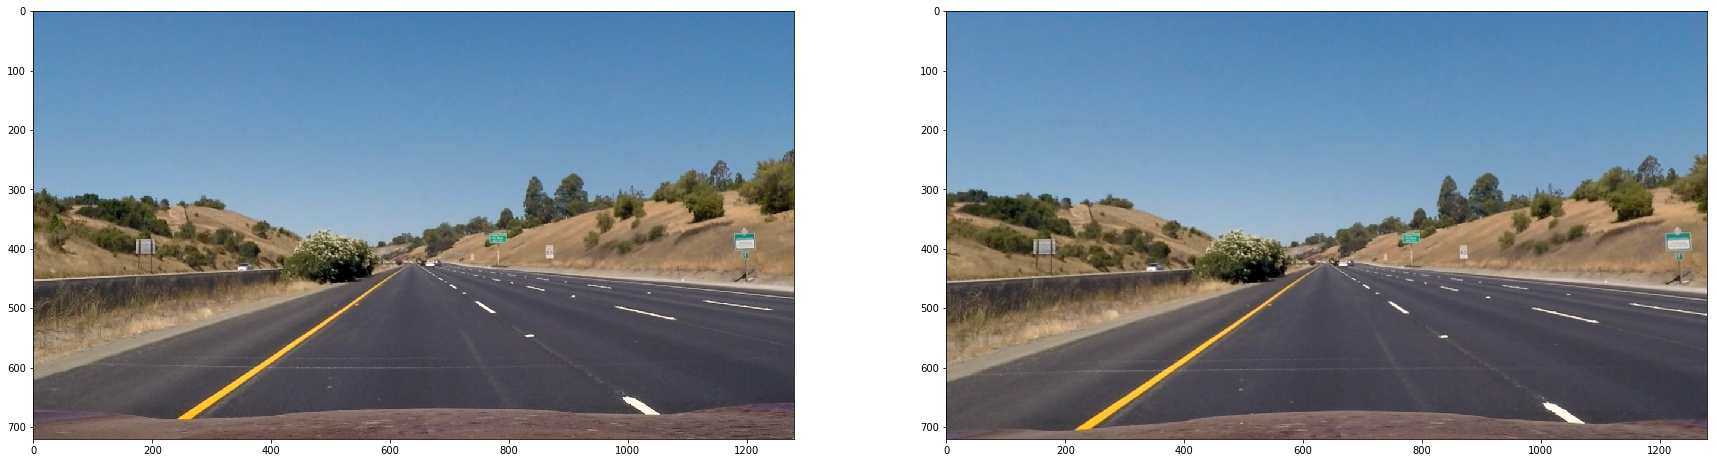

In [7]:
# display undistorted image example

print("Undistorting image...")
filenameList = [fn for fn in os.listdir(TEST_DIR) if fn.endswith('.jpg')]
fn = random.choice(filenameList)
imOriginal = cv2.imread(os.path.join(TEST_DIR,fn))
imOriginalRGB = cv2.cvtColor(imOriginal,cv2.COLOR_BGR2RGB)
imUndistorted = cv2.undistort(imOriginalRGB,mtx,dst)

f2 = plt.figure(figsize=(30,40))
ax = f2.add_subplot(1,2,1)
ax.imshow(imOriginalRGB)
ax = f2.add_subplot(1,2,2)
ax.imshow(imUndistorted)
plt.show()

In [8]:
# define lane pixel finder

def selectLanePixels(im, fn='frame.jpg'):
    # select pixels that are lane markers
    # go to HLS color space and use sobel x gradient

    hls = cv2.cvtColor(im,cv2.COLOR_BGR2HLS)
    lab = cv2.cvtColor(im,cv2.COLOR_BGR2LAB)
    gray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)

    # find yellow pixels (HSL)
    sChannel = hls[:,:,2]
    sBinary = np.zeros_like(sChannel)
    sBinary[ (sChannel > S_THRESHOLD[0]) & (sChannel <= S_THRESHOLD[1]) ] = 255

    # find white pixels (HSL)
    # inspired by https://stackoverflow.com/questions/22588146/tracking-white-color-using-python-opencv
    #lChannel = hls[:,:,1]
    #lBinary = np.zeros_like(lChannel)
    #lBinary[ (lChannel > L_THRESHOLD[0]) & (lChannel <= L_THRESHOLD[1]) ] = 255

    # find white pixels (LAB)
    lChannel = lab[:,:,0]
    lBinary = np.zeros_like(lChannel)
    lBinary[ (lChannel > L_THRESHOLD_LAB[0]) & (lChannel <= L_THRESHOLD_LAB[1]) ] = 255

    # find x gradient in range (Sobel)
    sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0)
    absSobelX = np.absolute(sobelx)
    sobelScaled = np.uint8(255 * absSobelX / np.max(absSobelX))
    sobelBinary = np.zeros_like(gray)
    sobelBinary[ (sobelScaled > SOBEL_THRESHOLD[0]) & (sobelScaled <= SOBEL_THRESHOLD[1]) ] = 255

    # make combined mask
    lanePixels = np.zeros_like(sChannel)
    lanePixels[ (sBinary > 0) | (lBinary > 0) | (sobelBinary > 0) ] = 255

    if fn != 'frame.jpg':
        cv2.imwrite(os.path.join(OUTPUT_DIR_S_CHANNEL,fn),sBinary)
        cv2.imwrite(os.path.join(OUTPUT_DIR_X_GRAD,fn),sobelBinary)

    return lanePixels

Finding example lane pixels...


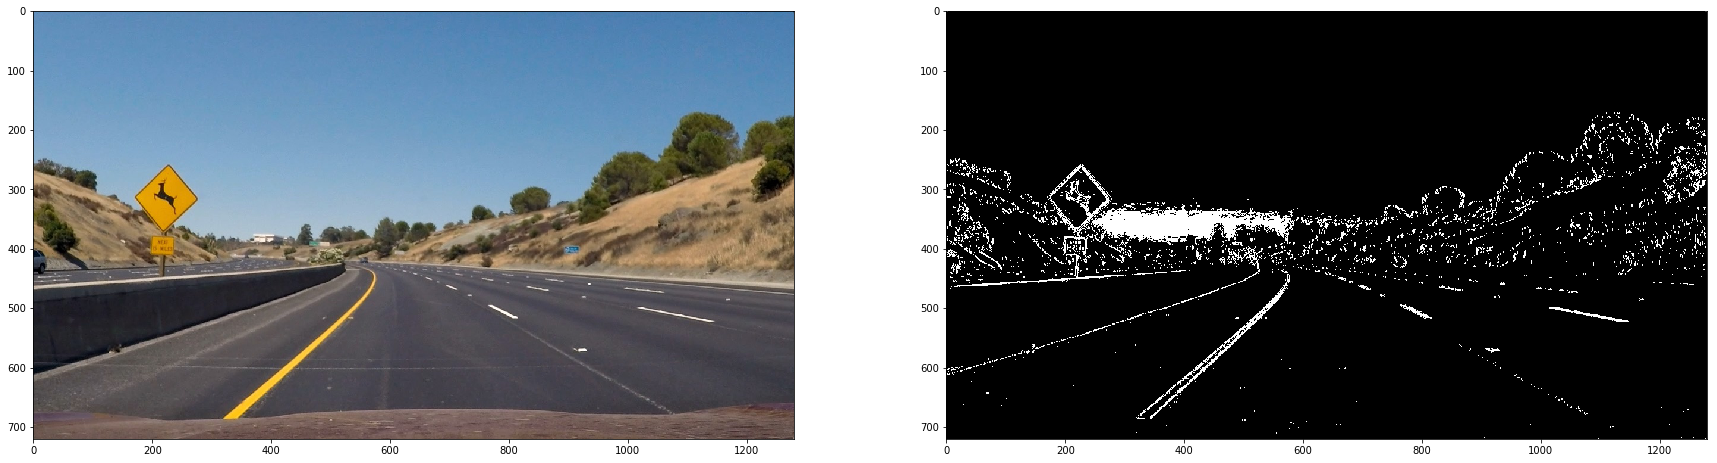

In [9]:
# display example lane pixel finder

print("Finding example lane pixels...")

filenameList = [fn for fn in os.listdir(TEST_DIR) if fn.endswith('.jpg')]
fn = random.choice(filenameList)
imBGR = cv2.imread(os.path.join(TEST_DIR,fn))
imRGB = cv2.cvtColor(imBGR,cv2.COLOR_BGR2RGB)

lanePixels = selectLanePixels(imRGB,fn)

f = plt.figure(figsize=(30,40))
ax = f.add_subplot(1,2,1)
ax.imshow(imRGB)
ax = f.add_subplot(1,2,2)
ax.imshow(lanePixels,cmap='gray')
plt.show()

In [10]:
# define utility function for selecting roi

def selectRoi(im):
    # mask out any pixels outside of the roi

    #rows,cols = im.shape[:2]
    bottomLeft = [0,ROWS*ROI_BOTTOM]
    topLeft = [COLS*ROI_LEFT,ROWS*ROI_TOP]
    topRight = [COLS*ROI_RIGHT,ROWS*ROI_TOP]
    bottomRight = [COLS,ROWS*ROI_BOTTOM]
    vertices = np.array([[bottomLeft,topLeft,topRight,bottomRight]],dtype=np.int32)
    mask = np.zeros_like(im)
    cv2.fillPoly(mask,vertices,255)
    
    return cv2.bitwise_and(im,mask)

# define utility function for determining line intersection

def findIntersection(lines):
    # find the point minimizing lsq distance from all lines
    # if the lines all intersect, this is the intersection point

    numLines = len(lines)
    a = np.zeros((numLines,2),dtype=np.float32)
    b = np.zeros((numLines,),dtype=np.float32)
    for n,line in enumerate(lines):
        for x1,y1,x2,y2 in line:
            slope = (y2-y1) / float(x2-x1)
            a[n] = np.array([slope,-1],dtype=np.float32)
            b[n] = slope * x1 - y1     # this is -1 times the intercept
    return np.linalg.lstsq(a,b)[0]

# define utility function for finding vanishing point

def findVanishingPoint(mtx,dst):
    # determine vanishing point in image

    # analyze straight-road images used to find vanishing point
    straightImages = [os.path.join(TEST_DIR,f) for f in os.listdir(TEST_DIR) if 'straight' in f]
    vps = []
    for imFile in straightImages:
        im = cv2.imread(imFile)
        im = cv2.undistort(im,mtx,dst)

        # smooth with gaussian blur
        imSmoothed = cv2.GaussianBlur(im,(GB_KERNEL,GB_KERNEL),0)

        # find edges with canny
        edges = cv2.Canny(imSmoothed,CANNY_LOW,CANNY_HIGH)

        # apply roi mask
        edgesRoi = selectRoi(edges)
        
        # find lines with hough; use probabilistic version to increase speed
        lines = cv2.HoughLinesP(edgesRoi,HOUGH_DIST_RES,HOUGH_ANGLE_RES,HOUGH_THRESHOLD,None,HOUGH_MIN_LINE,HOUGH_MAX_GAP)
        
        # identify best overlap point of lines - this is the vanishing point
        vp = findIntersection(lines)
        vps.append(vp)

        # save image
        for line in lines:
            for x1,y1,x2,y2 in line:
                cv2.line(im, (x1,y1), (x2,y2), GREEN_COLOR, thickness=2) 
        cv2.circle(im,(vp[0],vp[1]),8,GREEN_COLOR,2)
        savepath = os.path.join(OUTPUT_DIR_VP,os.path.split(imFile)[1])
        cv2.imwrite(savepath,im)

    # return arithmetic mean of vp coordinates
    return np.mean(vps,axis=0)

Calculating vanishing point...
Vanishing point: [ 639.17626953  419.63012695]


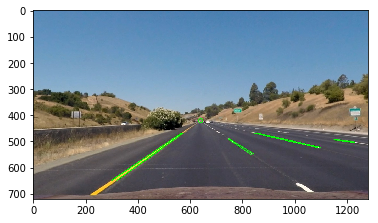

In [11]:
# display example of vanishing point

print("Calculating vanishing point...")
vp = findVanishingPoint(mtx,dst)
print("Vanishing point: {0}".format(vp))
filenameList = [fn for fn in os.listdir(OUTPUT_DIR_VP) if fn.endswith('.jpg')]
fn = random.choice(filenameList)
imBGR = cv2.imread(os.path.join(OUTPUT_DIR_VP,fn))
imRGB = cv2.cvtColor(imBGR,cv2.COLOR_BGR2RGB)
plt.imshow(imRGB)
plt.show()


In [12]:
# define function for calculating perspective transform

def calculatePerspectiveTransform():
    # calculate perspective transform matrix

    # read in camera calibration
    with open(CALIBRATION_FILENAME,'rb') as f:
        calibrationData = pickle.load(f)
    mtx = calibrationData['cam_matrix']
    dst = calibrationData['dist_coeffs']

    # find vanishing point; note this is returned as (x,y)
    vp = findVanishingPoint(mtx,dst)
        
    xVP,yVP = int(vp[0]),int(vp[1])
    xBottomLeft = int(ROI_LEFT * COLS)
    xBottomRight = int(ROI_RIGHT * COLS)
    yTop = int(ROWS * ROI_TOP)
    yBottom = int(ROWS * ROI_BOTTOM)
    
    # calculate x positions of upper ROI corners
    # x = my + b; m = (x1-x0)/(y1-y0); b = x0 - m * y0
    leftM = (xVP - xBottomLeft) / float(yVP - yBottom)    
    leftB = xBottomLeft - leftM * yBottom
    rightM = (xVP - xBottomRight) / float(yVP - yBottom)
    rightB = xBottomRight - rightM * yBottom
    xTopLeft = int(leftM * yTop + leftB)
    xTopRight = int(rightM * yTop + rightB)
            
    corners = [(xTopLeft,yTop),(xBottomLeft,yBottom),(xBottomRight,yBottom),(xTopRight,yTop)]
    pts1 = np.float32(corners)  
    pts2 = np.float32( [[0,0],[0,ROWS],[COLS,ROWS],[COLS,0]] )
    
    perspectiveTrans = cv2.getPerspectiveTransform(pts1,pts2)
    inversePerspectiveTrans = cv2.getPerspectiveTransform(pts2,pts1)

    transformDict = {'forwardWarp': perspectiveTrans, 'backwardWarp': inversePerspectiveTrans,'corners': corners}

    with open(PERSPECTIVE_FILENAME,'wb') as f:
        pickle.dump(transformDict,f)

    return transformDict

Warping perspective forward and backward...


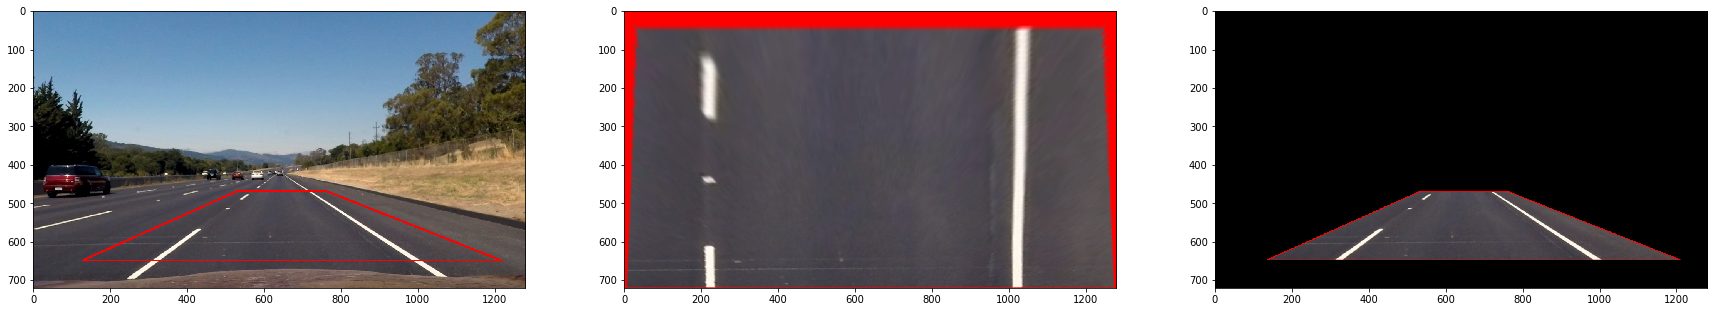

In [13]:
# display example perspective warp

print("Warping perspective forward and backward...")

td = calculatePerspectiveTransform()
p = td['corners']

filenameList = [fn for fn in os.listdir(TEST_DIR) if fn.endswith('.jpg') and 'straight' in fn]
fn = random.choice(filenameList)
im = cv2.imread(os.path.join(TEST_DIR,fn))
im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
im = cv2.undistort(im,mtx,dst)

cv2.line(im,p[0],p[1],color=(255,0,0),thickness=4)
cv2.line(im,p[1],p[2],color=(255,0,0),thickness=4)
cv2.line(im,p[2],p[3],color=(255,0,0),thickness=4)
cv2.line(im,p[3],p[0],color=(255,0,0),thickness=4)

imWarped = cv2.warpPerspective(im,td['forwardWarp'],(COLS,ROWS))
imWarpedBack = cv2.warpPerspective(imWarped,td['backwardWarp'],(COLS,ROWS))

f = plt.figure(figsize=(30,40))
ax = f.add_subplot(1,3,1)
ax.imshow(im)
ax = f.add_subplot(1,3,2)
ax.imshow(imWarped)
ax = f.add_subplot(1,3,3)
ax.imshow(imWarpedBack)
plt.show()

In [14]:
# define function to draw lane on image

def drawLane(im,leftLane,rightLane,inversePerspectiveTrans):
    # draw lane on image 

    # get pixels in lane from fits (in warped space)
    yPixelVals = range(ROWS)
    
    if TEST_MODE:
        # don't average
        leftFit = leftLane.recentFits[0]
        rightFit = rightLane.recentFits[0]
    else:
        # video mode; do average
        leftFit = np.mean(leftLane.recentFits,axis=0)
        rightFit = np.mean(rightLane.recentFits,axis=0)
        
    fitLeft = np.poly1d(leftFit)
    fitRight = np.poly1d(rightFit)
    xPixelValsLeft = fitLeft(yPixelVals)
    xPixelValsRight = fitRight(yPixelVals)

    pts = zip(yPixelVals,xPixelValsLeft,xPixelValsRight)

    # draw lane on warped image
    imLaneWarped = np.zeros((ROWS,COLS,3),np.uint8)
    for p in pts:
        imLaneWarped[p[0],int(p[1]):int(p[2]),:] = GREEN_COLOR

    # warp image back and combine with original image
    imLane = cv2.warpPerspective(imLaneWarped,inversePerspectiveTrans,(COLS,ROWS))    
    imLane = cv2.addWeighted(im,1,imLane,0.5,0)

    # calculate curvature
    curveLeft = leftLane.calculateCurvature(leftFit)
    curveRight = rightLane.calculateCurvature(rightFit)
    curveMean = 0.5 * (curveLeft + curveRight)
    curveStr = 'Lane curvature: {:06.2f} m'.format(curveMean)
    cv2.putText(imLane,curveStr,(100,90),cv2.FONT_HERSHEY_SIMPLEX,1.5,(255,255,255),thickness=2)

    # calculate lane center
    centerOffset = 0.5*(COLS-fitLeft(ROWS)-fitRight(ROWS)) * XM_PER_PIX
    centerStr = 'Lane offset: {:3.2f} m'.format(centerOffset)
    cv2.putText(imLane,centerStr,(100,140),cv2.FONT_HERSHEY_SIMPLEX,1.5,(255,255,255),thickness=2)

    return imLane

In [15]:
# define main routine for lane finding

def findLane(im):
    # main routine for lane finding

    # read file and undistort
    imUndistorted = cv2.undistort(im,mtx,dst)

    # find lane pixels
    imBinary = selectLanePixels(imUndistorted)

    # transform perspective
    imWarped = cv2.warpPerspective(imBinary,perspectiveTrans,(COLS,ROWS))

    # find lanes and fit to polynomial    
    yVals = range(ROWS,0,-WIN_HEIGHT) 
    imLeftFit = leftLane.findAndFit(imWarped,yVals)
    imRightFit = rightLane.findAndFit(imWarped,yVals)

    # draw lane on image
    imLane = drawLane(imUndistorted,leftLane,rightLane,inversePerspectiveTrans)

    if RECORD:

        # draw sliding window markers if recording
        imSlidingWindows = np.zeros_like(imRightFit,np.uint8)
        midLeft = int(np.floor(COLS/2))
        midRight = int(np.ceil(COLS/2))
        fullRight = COLS
        imSlidingWindows[:,0:midLeft,:] = imLeftFit[:,0:midLeft,:] 
        imSlidingWindows[:,midRight:fullRight,:] = imRightFit[:,midRight:fullRight,:] 

        # save images at various processing stages
        cv2.imwrite(os.path.join(OUTPUT_DIR_UNDISTORT,imageFile),imUndistorted)
        cv2.imwrite(os.path.join(OUTPUT_DIR_MARKER_PIXELS,imageFile),imBinary)
        cv2.imwrite(os.path.join(OUTPUT_DIR_WARPED,imageFile),imWarped)
        cv2.imwrite(os.path.join(OUTPUT_DIR_SLIDING_WINDOW,imageFile),imSlidingWindows)
        cv2.imwrite(os.path.join(OUTPUT_DIR_LANE_MARK,imageFile),imLane)

    return imLane

In [16]:
# do video processing

# read in camera calibration or perform calibration if pickled file is unavailable
try:
    with open(CALIBRATION_FILENAME,'rb') as f:
        calibrationData = pickle.load(f)
        mtx = calibrationData['cam_matrix']
        dst = calibrationData['dist_coeffs']
        print("Read camera calibration from file...")
except:
    print("Performing camera calibration...")
    mtx,dst = calibrateCamera()

# read in perspective transform or perform transform matrix calculation if pickled file is unavailable
try:
    with open(PERSPECTIVE_FILENAME,'rb') as f:
        transformDict = pickle.load(f)
        perspectiveTrans = transformDict['forwardWarp']
        inversePerspectiveTrans = transformDict['backwardWarp']
    print("Read perspective transform from file...")
except:
    print("Performing perspective transform...")
    transformDict = calculatePerspectiveTransform()
    perspectiveTrans = transformDict['forwardWarp']
    inversePerspectiveTrans = transformDict['backwardWarp']

# set up lane line objects
leftLane = LaneLine('left')
rightLane = LaneLine('right')

# if we're in test mode, analyze test images
if TEST_MODE:
    for imageFile in os.listdir(TEST_DIR):
        if imageFile.endswith('.jpg') and 'straight' not in imageFile:
            print('Loading image {0}...'.format(imageFile))
            fn = os.path.join(TEST_DIR,imageFile)
            im = cv2.imread(fn)
            findLane(im)

else:
    # we're in video mode
    video_output = 'output_video/video_output.mp4'
    clip = VideoFileClip('./project_video.mp4')
    clip_out = clip.fl_image(findLane)
    clip_out.write_videofile(video_output, audio=False)


Read camera calibration from file...
Read perspective transform from file...
[MoviePy] >>>> Building video output_video/video_output.mp4
[MoviePy] Writing video output_video/video_output.mp4


100%|█████████▉| 1260/1261 [02:38<00:00,  7.32it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video/video_output.mp4 

